# IMPORT LIBRARY

In [43]:
import faulthandler 
from pyspark.sql import SparkSession 
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.types import ArrayType, DoubleType, BooleanType, DateType, FloatType, TimestampType
from pyspark.sql.functions import col, array_contains, isnan, when, count
from pyspark.sql.functions import lit, concat_ws, concat, collect_list, udf
from pyspark.sql.functions import countDistinct
import plotly.express as px
import os
import seaborn as sns
import matplotlib.pyplot as plt

## spark 접속

In [2]:

faulthandler.enable()   
spark = SparkSession.builder.master('local').appName('Python Spark SQL Practice').getOrCreate()

# DATA LOAD

In [3]:
def search(dirname):
    filenames = os.listdir(dirname)
    file_list = []
    for filename in filenames:
        full_filename = os.path.join(dirname, filename)
        print(full_filename)
        file_list.append(full_filename)
    return file_list
data_path_list = search("D:/workspace/data/")

D:/workspace/data/2019-Dec.csv
D:/workspace/data/2019-Nov.csv
D:/workspace/data/2019-Oct.csv
D:/workspace/data/2020-Apr.csv
D:/workspace/data/2020-Feb.csv
D:/workspace/data/2020-Jan.csv
D:/workspace/data/2020-Mar.csv


## 스키마 타입

In [4]:
schema = StructType() \
      .add("event_time",TimestampType(),True) \
      .add("event_type",StringType(),True) \
      .add("product_id",StringType(),True) \
      .add("category_id",StringType(),True) \
      .add("category_code",StringType(),True) \
      .add("brand",StringType(),True) \
      .add("price",DoubleType(),True) \
      .add("user_id",StringType(),True) \
      .add("user_session",StringType(),True)

## data merge
    - 2019년 10월 ~ 2020년 4월

In [5]:
for i, x in enumerate(data_path_list):
    file_path = x
    df = spark.read.format("csv") \
      .option("header", True) \
      .option('delimiter', ',') \
      .schema(schema) \
      .load(file_path)
    if i == 0:
        merged_df = df
    else:
        merged_df = merged_df.union(df)

In [6]:
merged_df.show()

+-------------------+----------+----------+-------------------+--------------------+-------+-------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code|  brand|  price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+-------+-------+---------+--------------------+
|2019-12-01 09:00:00|      view|   1005105|2232732093077520756|construction.tool...|  apple|1302.48|556695836|ca5eefc5-11f9-450...|
|2019-12-01 09:00:00|      view|  22700068|2232732091643068746|                NULL|  force| 102.96|577702456|de33debe-c7bf-44e...|
|2019-12-01 09:00:01|      view|   2402273|2232732100769874463|appliances.person...|  bosch| 313.52|539453785|5ee185a7-0689-4a3...|
|2019-12-01 09:00:02|  purchase|  26400248|2053013553056579841|computers.periphe...|   NULL| 132.31|535135317|61792a26-672f-4e6...|
|2019-12-01 09:00:02|      view|  20100164|2232732110089618156|    apparel.t

## spark table 생성

In [7]:
merged_df.createOrReplaceTempView("ecommerce")

# 1. ACQUISITION(고객 유치) 

## 1) DAU (Daily Active User)

### DAU 쿼리

In [8]:
dau = spark.sql("""
SELECT DATE(event_time) AS event_date, COUNT(DISTINCT user_id) AS DAU
FROM ecommerce
GROUP BY event_date
ORDER BY event_date
""")

In [9]:
dau.show()

+----------+------+
|event_date|   DAU|
+----------+------+
|2019-10-01|138532|
|2019-10-02|191269|
|2019-10-03|171202|
|2019-10-04|204000|
|2019-10-05|195812|
|2019-10-06|194376|
|2019-10-07|189661|
|2019-10-08|216037|
|2019-10-09|216194|
|2019-10-10|203411|
|2019-10-11|233042|
|2019-10-12|209497|
|2019-10-13|225661|
|2019-10-14|209438|
|2019-10-15|227812|
|2019-10-16|232011|
|2019-10-17|211813|
|2019-10-18|224919|
|2019-10-19|220472|
|2019-10-20|230312|
+----------+------+
only showing top 20 rows



### DAU 그래프

## 2) MAU(Monthly Active User)

### MAU 쿼리

In [10]:
mau = spark.sql("""
SELECT DATE_FORMAT(event_time, 'yyyy-mm') AS event_month, COUNT(DISTINCT user_id) AS DAU
FROM ecommerce
GROUP BY event_month
ORDER BY event_month
""")

In [11]:
mau.show()

+-----------+-------+
|event_month|    DAU|
+-----------+-------+
|    2019-00|1280672|
|    2019-01|1274393|
|    2019-02|1267876|
|    2019-03|1266610|
|    2019-04|1269594|
|    2019-05|1276898|
|    2019-06|1276221|
|    2019-07|1280162|
|    2019-08|1280832|
|    2019-09|1281906|
|    2019-10|1281675|
|    2019-11|1284426|
|    2019-12|1286149|
|    2019-13|1284303|
|    2019-14|1286483|
|    2019-15|1288085|
|    2019-16|1288663|
|    2019-17|1287799|
|    2019-18|1287940|
|    2019-19|1288514|
+-----------+-------+
only showing top 20 rows



### MAU 그래프

# 2. ACTIVATION(활성화)

## 1) DT(Duration Time, 체류 시간)

### DT 쿼리

In [12]:
duration = spark.sql('''SELECT user_session, 
                                MONTH(MAX(event_time)) AS DURATION_MONTH,
                                DATE(MAX(event_time)) AS DURATION_DATE,
                               MAX(event_time) - MIN(event_time) AS duration
                  FROM ecommerce 
                  GROUP BY user_session
                  '''
          )

In [13]:
duration.show()

+--------------------+--------------+-------------+--------------------+
|        user_session|DURATION_MONTH|DURATION_DATE|            duration|
+--------------------+--------------+-------------+--------------------+
|6ab5b6db-c510-4bf...|            12|   2019-12-01|INTERVAL '0 00:11...|
|65af5191-b1f4-48f...|            12|   2019-12-01|INTERVAL '0 00:02...|
|85433431-f690-457...|            12|   2019-12-01|INTERVAL '0 00:00...|
|58ccc335-aec1-441...|            12|   2019-12-01|INTERVAL '0 00:00...|
|401786ed-0a16-4b8...|            12|   2019-12-01|INTERVAL '0 00:04...|
|d1172b13-34ef-4b2...|            12|   2019-12-01|INTERVAL '0 00:00...|
|ad4ddec9-f4d2-4fb...|            12|   2019-12-01|INTERVAL '0 00:29...|
|b856e5bf-c31a-475...|            12|   2019-12-01|INTERVAL '0 00:01...|
|16ff28f3-38e4-47f...|            12|   2019-12-01|INTERVAL '0 00:00...|
|96528bd9-afba-4c2...|            12|   2019-12-01|INTERVAL '0 00:00...|
|0cc48385-9a5d-4fe...|            12|   2019-12-01|

## 2) 구매까지 걸리는 DT

### duration 테이블 만들기

In [14]:
duration.createOrReplaceTempView('duration_table')

### user_session 별로 view, purchase, cart의 수

In [15]:
pivot_session = spark.sql('''WITH source AS (
                                                SELECT user_session, event_type, COUNT(event_time) AS event_count
                                                FROM ecommerce
                                                GROUP BY user_session, event_type
                                                )
                            SELECT 
                                user_session,
                                SUM(CASE WHEN event_type = 'view' THEN event_count ELSE 0 END) AS view,
                                SUM(CASE WHEN event_type = 'cart' THEN event_count ELSE 0 END) AS cart,
                                SUM(CASE WHEN event_type = 'purchase' THEN event_count ELSE 0 END) AS purchase
                            FROM source
                            GROUP BY user_session
                            ORDER BY user_session
                        ''')

In [16]:
pivot_session.createOrReplaceTempView('session_pivot_table')

### 구매 이력이 있는 섹션의 DT

In [17]:
purchase_session_avg_duration = spark.sql('''
                                                SELECT MEAN(d.duration)
                                                FROM duration_table AS d, 
                                                    (SELECT user_session, purchase
                                                    FROM session_pivot_table
                                                    WHERE purchase > 0)   AS p
                                                WHERE d.user_session = p.user_session
                                        ''')

In [18]:
purchase_session_avg_duration.show()

+--------------------+
|      mean(duration)|
+--------------------+
|INTERVAL '2 01:41...|
+--------------------+



## 3) 월간 DT

### 월간 DT 쿼리

In [48]:
duration_month = spark.sql("""
WITH temp AS (
    SELECT user_session, 
    MONTH(MAX(event_time)) AS DURATION_MONTH,
    DATE(MAX(event_time)) AS DURATION_DATE,
    MAX(event_time) - MIN(event_time) AS duration
    FROM ecommerce 
    GROUP BY user_session
)
SELECT DURATION_DATE, AVG(duration) AS AVG_DURATION
FROM temp
GROUP BY DURATION_DATE
ORDER BY DURATION_DATE
""")

In [49]:
duration_month.show()

+-------------+--------------------+
|DURATION_DATE|        AVG_DURATION|
+-------------+--------------------+
|   2019-10-01|INTERVAL '0 00:04...|
|   2019-10-02|INTERVAL '0 00:07...|
|   2019-10-03|INTERVAL '0 00:10...|
|   2019-10-04|INTERVAL '0 00:10...|
|   2019-10-05|INTERVAL '0 00:11...|
|   2019-10-06|INTERVAL '0 00:13...|
|   2019-10-07|INTERVAL '0 00:14...|
|   2019-10-08|INTERVAL '0 00:15...|
|   2019-10-09|INTERVAL '0 00:14...|
|   2019-10-10|INTERVAL '0 00:15...|
|   2019-10-11|INTERVAL '0 00:14...|
|   2019-10-12|INTERVAL '0 00:16...|
|   2019-10-13|INTERVAL '0 00:15...|
|   2019-10-14|INTERVAL '0 00:16...|
|   2019-10-15|INTERVAL '0 00:15...|
|   2019-10-16|INTERVAL '0 00:15...|
|   2019-10-17|INTERVAL '0 00:15...|
|   2019-10-18|INTERVAL '0 00:14...|
|   2019-10-19|INTERVAL '0 00:13...|
|   2019-10-20|INTERVAL '0 00:13...|
+-------------+--------------------+
only showing top 20 rows



## 4) FUNNEL (EVENT_TYPE 별 COUNT)

### FUNNEL 쿼리

In [21]:
funnel = spark.sql("""
                   SELECT 
                        event_type, COUNT(*) AS CNT
                   FROM 
                        ecommerce
                   GROUP BY 
                        event_type
                   ORDER BY
                        CNT DESC
""")

In [22]:
funnel.show()

+----------+---------+
|event_type|      CNT|
+----------+---------+
|      view|385746849|
|      cart| 19114063|
|  purchase|  6848824|
+----------+---------+



In [23]:
df_funnel = funnel.toPandas()

In [24]:
df_funnel

,event_type,CNT
0,view,385746849
1,cart,19114063
2,purchase,6848824


### FUNNEL 그래프

In [25]:
fig = px.funnel(data_frame= df_funnel, x = 'event_type', y = 'CNT')
fig.update_traces(texttemplate= '%{value:,.0f}') # 숫자 형식 지정
fig.show()

# 3. RETENTION(리텐션)

## 1) Monthly Retention
    - 접속 했는지 여부

### 월간 리텐션 쿼리

In [26]:
retention_range_30 = spark.sql("""
                               WITH first as (
                                    SELECT user_id, MIN(event_time) AS first_interaction_time
                                    FROM ecommerce
                                    GROUP BY user_id
                                )

                                SELECT MONTH(first_interaction_time) AS MONTH, FLOOR(MONTHS_BETWEEN(event_time, first_interaction_time)) AS diff_month,
                                COUNT(DISTINCT s.user_id) as user_cnt
                                FROM ecommerce s LEFT JOIN first f
                                ON s.user_id = f.user_id
                                GROUP BY MONTH, FLOOR(MONTHS_BETWEEN(event_time, first_interaction_time))
                                ORDER BY diff_month

                          """)


In [27]:
retention_range_30.show()

+-----+----------+--------+
|MONTH|diff_month|user_cnt|
+-----+----------+--------+
|   11|         0| 2294808|
|    1|         0| 2152155|
|    4|         0| 2100242|
|   12|         0| 2534092|
|   10|         0| 3003621|
|    3|         0| 1692773|
|    2|         0| 1841332|
|    5|         0|   20780|
|   12|         1|  546728|
|    3|         1|  221144|
|   10|         1| 1274245|
|    4|         1|     353|
|    1|         1|  414526|
|    2|         1|  283300|
|   11|         1|  722024|
|   12|         2|  451912|
|   11|         2|  570435|
|    2|         2|  191446|
|    3|         2|     240|
|   10|         2| 1141914|
+-----+----------+--------+
only showing top 20 rows



### pandas, pivot 전환

In [28]:
df_retention_30 = retention_range_30.toPandas()

In [29]:
df_retention_30_pivot = df_retention_30.pivot(index='MONTH',columns='diff_month',values='user_cnt').reindex([10,11,12,1,2,3,4])

In [30]:
df_retention_30_pivot

diff_month,0,1,2,3,4,5,6,7
MONTH,,,,,,,,
10,3003621.0,1274245.0,1141914.0,952834.0,853271.0,720473.0,546060.0,2378.0
11,2294808.0,722024.0,570435.0,501031.0,399245.0,291355.0,471.0,NaN
12,2534092.0,546728.0,451912.0,336531.0,214911.0,313.0,NaN,NaN
1,2152155.0,414526.0,285484.0,191246.0,245.0,NaN,NaN,NaN
2,1841332.0,283300.0,191446.0,314.0,NaN,NaN,NaN,NaN
3,1692773.0,221144.0,240.0,NaN,NaN,NaN,NaN,NaN
4,2100242.0,353.0,NaN,NaN,NaN,NaN,NaN,NaN


### value 비율로 변환

In [31]:
for i in range(len(df_retention_30_pivot)):
    a = df_retention_30_pivot.iloc[i,0]
    for j in range(len(df_retention_30_pivot.columns)):
        if df_retention_30_pivot.isnull().iloc[i,j]:
            pass
        else:
            df_retention_30_pivot.iloc[i,j] = round(df_retention_30_pivot.iloc[i,j] / a, 4)


In [32]:
df_retention_30_pivot.to_csv("월간리텐션.csv", index=False)

### 월간 리텐션 그래프

<Axes: xlabel='diff_month', ylabel='MONTH'>

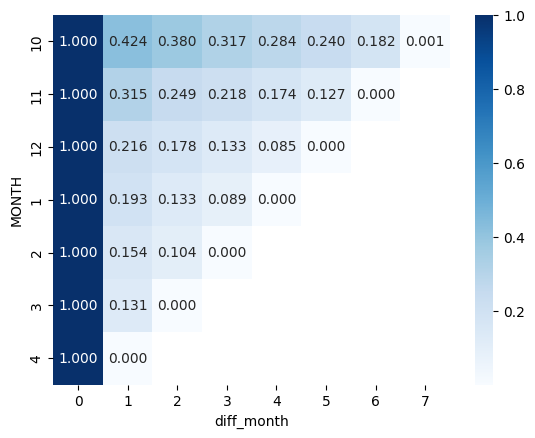

In [47]:

sns.heatmap(df_retention_30_pivot, annot=True, fmt=".3f", cmap = 'Blues')

[문제를 찾자]
전반적으로 10, 11월 retention 좋음

1~3월 폭망

그 이유는 무엇일까???

Q1.전체적인 건수가 줄어서???
그럼 왜 줄어 들었을까????

단순히 연초라서????
Q2.연말에 폭풍 소비 후 연초에 살 필요성이 없음????

아니면 제품군?????
EX. 컴퓨터나 장기간 사용할 물건을 구매해서 다시 들어갈 일이 생기지 않았나???
--> 블랙프레이데이를 이용해서 저런 것들을 구매 후 재방문으로는 이어지지 않았나???




## 2) Weekly Retention

### 주간 리텐션 쿼리

In [34]:
retention_range_7 = spark.sql("""
                               WITH first as (
                                    SELECT user_id, MIN(event_time) AS first_interaction_time
                                    FROM ecommerce
                                    GROUP BY user_id
                                )
                                SELECT DATE(DATE_TRUNC('week',first_interaction_time)) AS WEEK, 
                                CAST(DATEDIFF(s.event_time, f.first_interaction_time) / 7 AS INT) AS diff_week,
                                COUNT(DISTINCT s.user_id) as user_cnt
                                FROM ecommerce s LEFT JOIN first f
                                ON s.user_id = f.user_id
                                GROUP BY WEEK, diff_week
                                ORDER BY diff_week

                          """)


In [35]:
retention_range_7.show()

+----------+---------+--------+
|      WEEK|diff_week|user_cnt|
+----------+---------+--------+
|2019-12-23|        0|  663936|
|2020-01-13|        0|  513541|
|2020-02-17|        0|  541865|
|2019-09-30|        0|  818388|
|2020-02-24|        0|  383602|
|2020-03-23|        0|  261293|
|2020-03-16|        0|  263913|
|2020-01-06|        0|  490528|
|2019-12-30|        0|  614861|
|2020-03-30|        0|  305555|
|2020-04-20|        0|  566769|
|2019-11-25|        0|  437714|
|2019-10-14|        0|  617645|
|2020-04-06|        0|  421139|
|2019-11-18|        0|  551204|
|2019-12-09|        0|  517199|
|2020-01-20|        0|  461124|
|2020-04-13|        0|  569921|
|2019-12-16|        0|  637462|
|2020-02-10|        0|  484614|
+----------+---------+--------+
only showing top 20 rows



### pandas, pivot 전환

In [36]:
df_retention_7 = retention_range_7.toPandas()

In [37]:
df_retention_7.sort_values(by=['WEEK','diff_week'])

,WEEK,diff_week,user_cnt
4,2019-09-30,0,818388
34,2019-09-30,1,277762
79,2019-09-30,2,249026
105,2019-09-30,3,217328
132,2019-09-30,4,237233
...,...,...,...
51,2020-04-13,1,88037
72,2020-04-13,2,23189
10,2020-04-20,0,566769
43,2020-04-20,1,25032


In [38]:
df_retention_7_pivot = df_retention_7.pivot(index='WEEK',columns='diff_week',values='user_cnt')

In [39]:
df_retention_7_pivot

diff_week,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
WEEK,,,,,,,,,,,,,,,,,,,,,
2019-09-30,818388.0,277762.0,249026.0,217328.0,237233.0,237564.0,254368.0,189930.0,189973.0,182434.0,...,129174.0,144455.0,111112.0,100627.0,96393.0,97721.0,109433.0,116705.0,114075.0,34374.0
2019-10-07,762779.0,189777.0,158667.0,170302.0,177742.0,191278.0,139484.0,137583.0,132855.0,149478.0,...,108647.0,81747.0,71675.0,69064.0,70776.0,81816.0,88823.0,86552.0,29230.0,NaN
2019-10-14,617645.0,121323.0,122805.0,127420.0,138418.0,97092.0,95831.0,92950.0,105064.0,111131.0,...,55967.0,48729.0,47201.0,48838.0,56794.0,62710.0,61121.0,19997.0,NaN,NaN
2019-10-21,552380.0,100164.0,99091.0,103100.0,75901.0,71711.0,68842.0,78667.0,84997.0,75264.0,...,34923.0,33922.0,35402.0,42027.0,46786.0,46210.0,15310.0,NaN,NaN,NaN
2019-10-28,462835.0,91026.0,89511.0,63843.0,61109.0,58487.0,66737.0,69131.0,61277.0,51279.0,...,28532.0,29863.0,35053.0,38537.0,37522.0,10780.0,NaN,NaN,NaN,NaN
2019-11-04,564746.0,124909.0,83590.0,77329.0,74211.0,81056.0,86185.0,74464.0,62020.0,57031.0,...,35716.0,41833.0,46398.0,45374.0,14100.0,NaN,NaN,NaN,NaN,NaN
2019-11-11,592037.0,102670.0,90169.0,82371.0,94816.0,93315.0,80111.0,64344.0,61188.0,64710.0,...,46411.0,50524.0,48139.0,12360.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-18,551204.0,76492.0,67458.0,69977.0,72175.0,64730.0,52953.0,47623.0,50400.0,44158.0,...,32384.0,32671.0,10372.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-25,437714.0,66363.0,63482.0,61671.0,54092.0,44019.0,39915.0,40491.0,36213.0,36987.0,...,27940.0,8283.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### value 비율로 전환

In [40]:
for i in range(len(df_retention_7_pivot)):
    a = df_retention_7_pivot.iloc[i,0]
    for j in range(len(df_retention_7_pivot.columns)):
        if df_retention_7_pivot.isnull().iloc[i,j]:
            pass
        else:
            df_retention_7_pivot.iloc[i,j] = round(df_retention_7_pivot.iloc[i,j] / a, 4)


In [41]:
df_retention_7_pivot.to_csv("주간리텐션.csv", index=False)

### 주간 리텐션 그래프

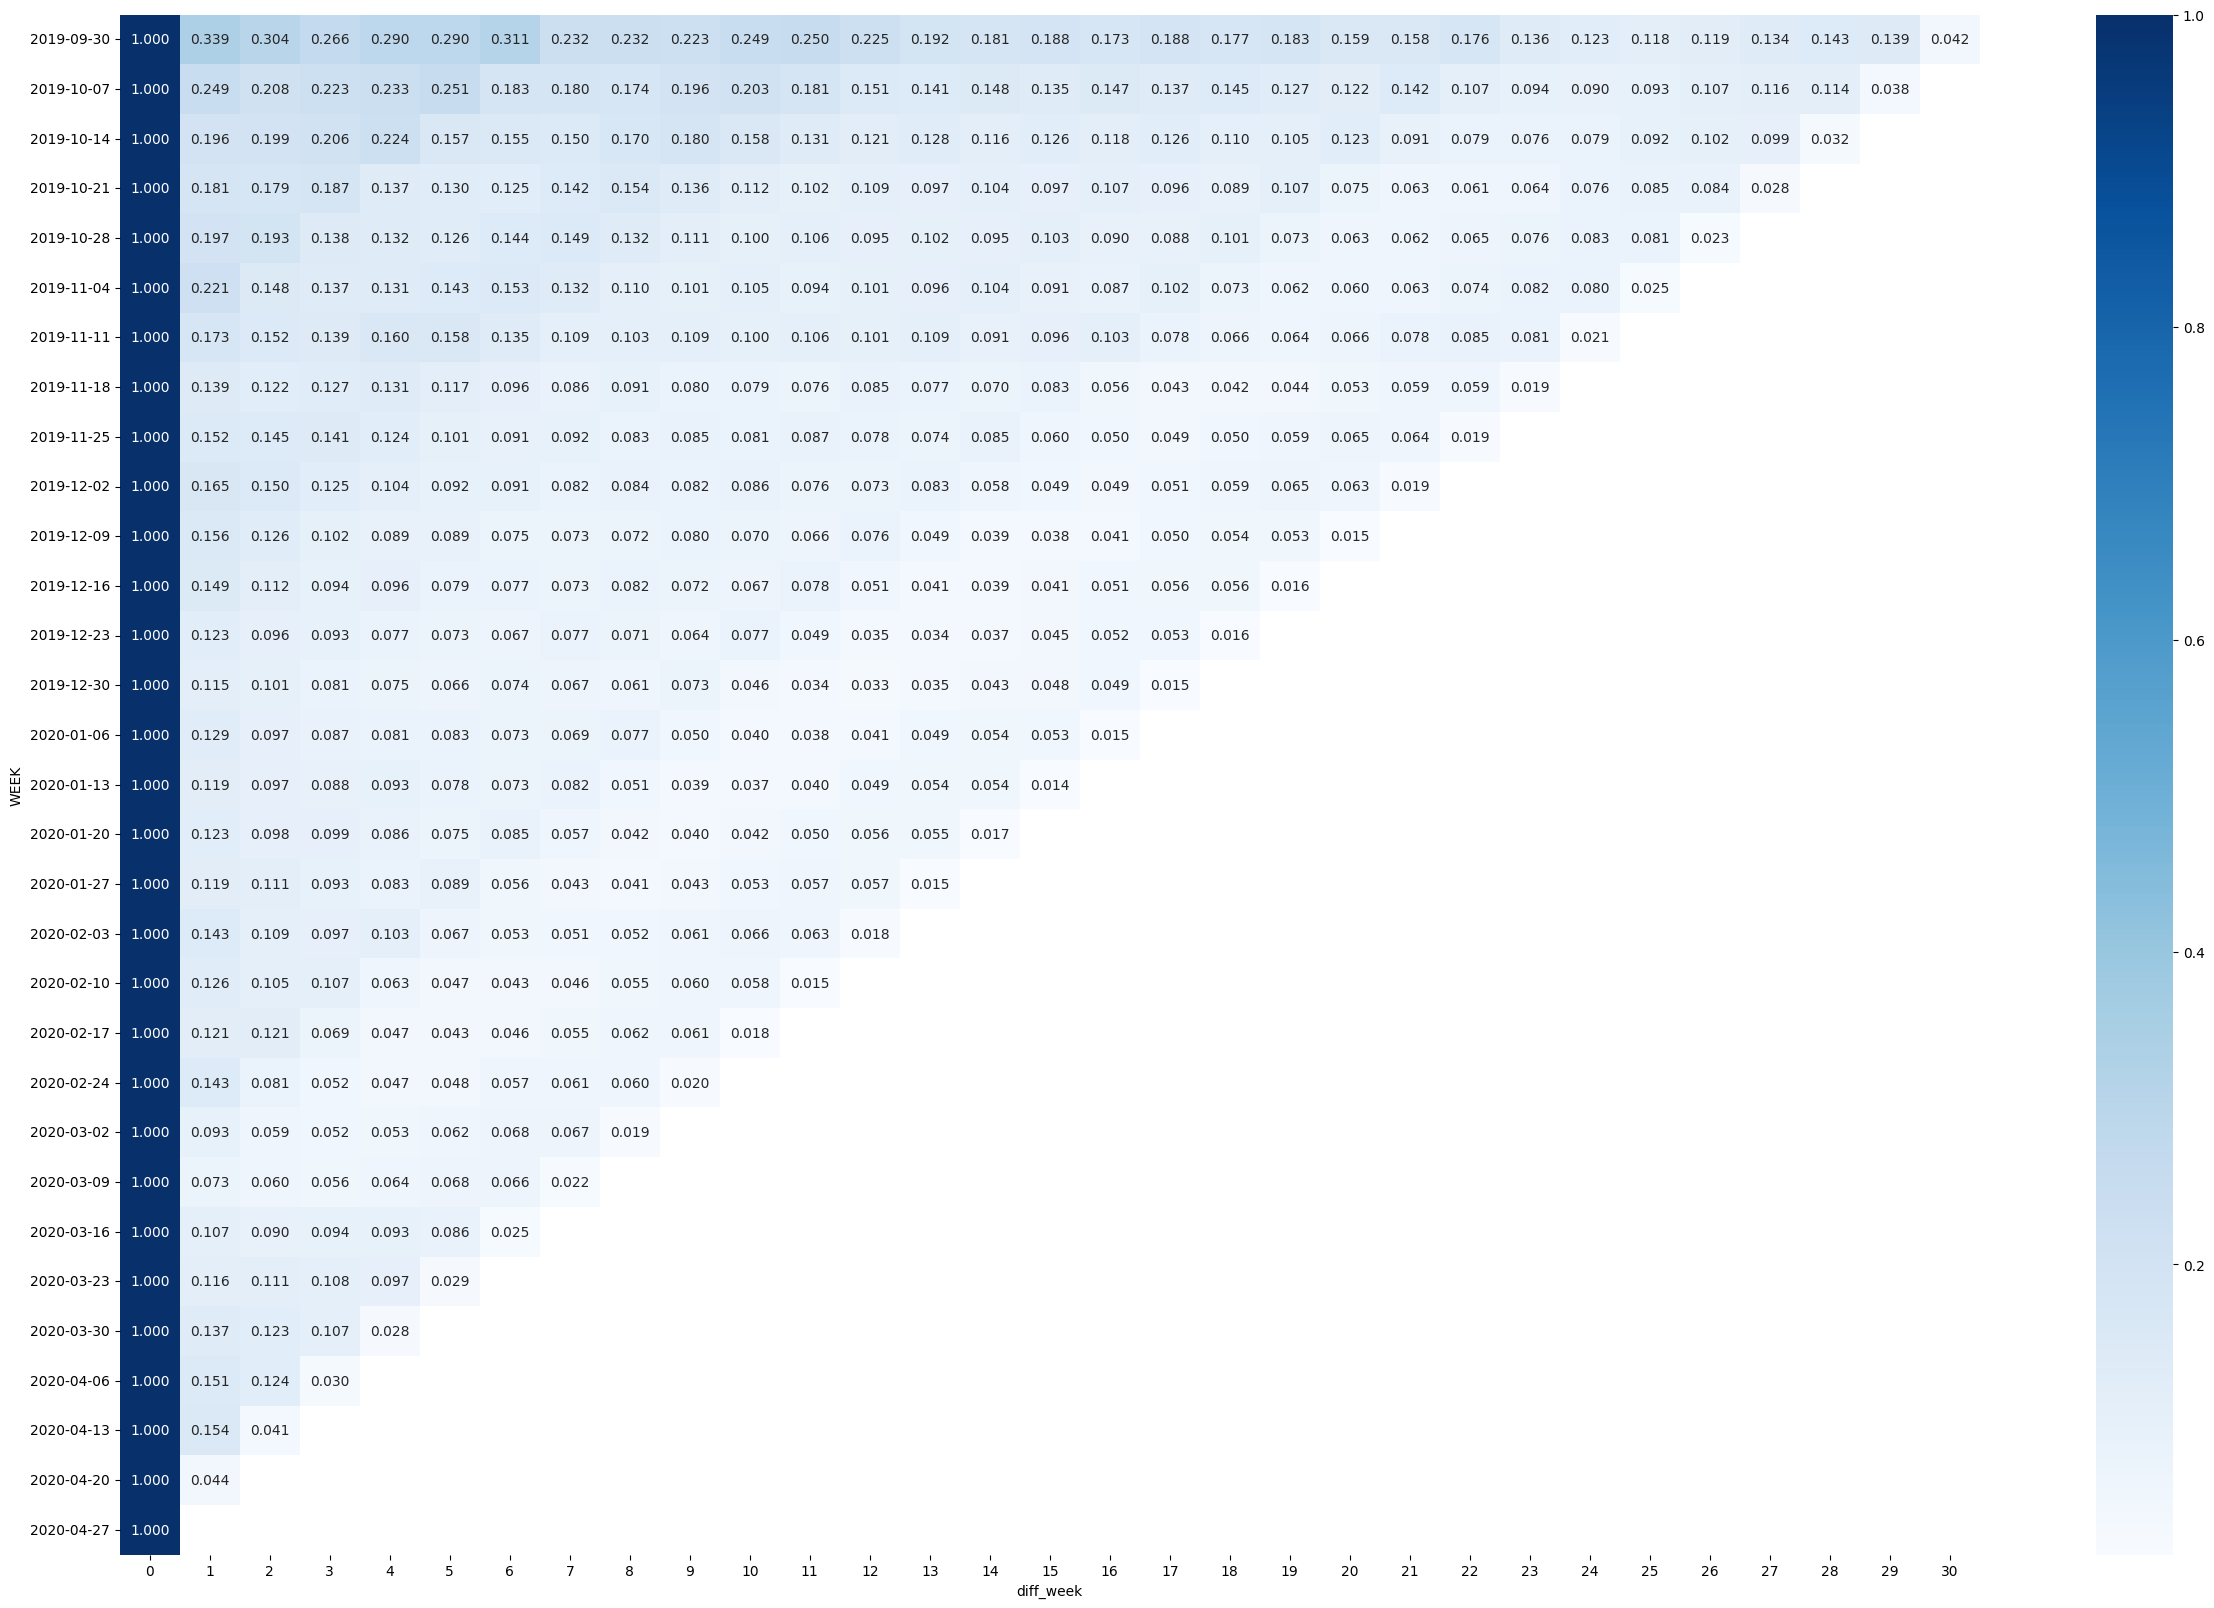

In [46]:
plt.figure(figsize=(30, 20))
sns.heatmap(df_retention_7_pivot, annot=True, fmt=".3f", cmap="Blues")
plt.show()

# SPARK STOP

In [ ]:
spark.stop()